In [6]:
# Cài đặt và Import thư viện
# Cài đặt và Import thư viện
import random
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import time
import sys
from heapq import heappush, heappop

print("Các thư viện đã được import.")

Các thư viện đã được import.


In [7]:
# Đo thời gian tổng
start_time_total = time.time()

# Data Generation và Shingling
def generate_random_string(min_len, max_len):
    length = random.randint(min_len, max_len)
    return ''.join(random.choice(string.ascii_lowercase) for _ in range(length))

def get_shingles(text, k=4):
    shingles = set()
    if text is None or len(text) < k:
        return shingles
    for i in range(len(text) - k + 1):
        shingles.add(text[i:i+k])
    return shingles

# Thông số
NUM_TOTAL_STRINGS = 10000
MIN_LENGTH = 32
MAX_LENGTH = 64
SHINGLE_K = 4
CSV_FILENAME = "generated_strings_with_shingles.csv"
SAMPLE_SIZE_FOR_CLUSTERING = 10000  # Giảm để thử nghiệm, tăng lên 10000 sau khi tối ưu
NUM_FINAL_CLUSTERS_TARGET = 5

print("--- Bước 1: Tạo dữ liệu và Shingling ---")
start_time = time.time()
data_to_generate = []
for i in range(NUM_TOTAL_STRINGS):
    original_string = generate_random_string(MIN_LENGTH, MAX_LENGTH)
    shingles_set = get_shingles(original_string, k=SHINGLE_K)
    data_to_generate.append({
        "index": i,
        "string": original_string,
        "shingles": shingles_set
    })

df_generated_all = pd.DataFrame(data_to_generate)
df_to_save_csv = df_generated_all.copy()
df_to_save_csv['shingles'] = df_to_save_csv['shingles'].apply(lambda s: list(s))
df_to_save_csv.to_csv(CSV_FILENAME, index=False)
print(f"Đã tạo và lưu {len(df_generated_all)} chuỗi vào file '{CSV_FILENAME}'.")
print(f"Thời gian tạo dữ liệu: {time.time() - start_time:.2f} giây")
print("-" * 30)

--- Bước 1: Tạo dữ liệu và Shingling ---
Đã tạo và lưu 10000 chuỗi vào file 'generated_strings_with_shingles.csv'.
Thời gian tạo dữ liệu: 0.60 giây
------------------------------


In [8]:
#Jaccard Distance Function
# Yêu cầu: Dùng Jaccard distance để đo sự khác biệt
def jaccard_distance(set1, set2):
    if not isinstance(set1, set):
        set1 = set(set1)
    if not isinstance(set2, set):
        set2 = set(set2)
    intersection_len = len(set1.intersection(set2))
    union_len = len(set1.union(set2))
    if union_len == 0:
        return 1.0  # Đề yêu cầu 1.0 cho trường hợp rỗng
    return 1.0 - intersection_len / union_len

print("\n--- Bước 2: Định nghĩa hàm Jaccard Distance ---")
# Test nhỏ (có thể bỏ qua khi nộp bài)
set_a = {'a', 'b', 'c'}
set_b = {'b', 'c', 'd'}
print(f"Test Jaccard Distance (A, B): {jaccard_distance(set_a, set_b)}") # Expected: 0.5
set_c = {'x', 'y'}
print(f"Test Jaccard Distance (A, C): {jaccard_distance(set_a, set_c)}") # Expected: 1.0
print(f"Test Jaccard Distance (A, A): {jaccard_distance(set_a, set_a)}") # Expected: 0.0
print("-" * 30)


--- Bước 2: Định nghĩa hàm Jaccard Distance ---
Test Jaccard Distance (A, B): 0.5
Test Jaccard Distance (A, C): 1.0
Test Jaccard Distance (A, A): 0.0
------------------------------


In [9]:
class AgglomerativeHierarchicalClustering:
    def __init__(self, distance_metric_func):
        self.distance_metric = distance_metric_func # jaccard_distance
        self.samples_data = [] # List các shingle sets gốc
        
        # Sử dụng ID cụm ổn định
        self.active_cluster_ids = set() # Set các ID của các cụm đang hoạt động
        self.cluster_members_map = {}   # Dict: cluster_id -> tuple_of_original_sample_indices
        self.clustroids_map = {}        # Dict: cluster_id -> original_sample_index_of_clustroid
        self.next_internal_cluster_id = 0 # Để tạo ID cụm duy nhất (số nguyên)

        self._sample_distance_cache = {}  # Cache khoảng cách Jaccard giữa các MẪU gốc

    def _get_cached_sample_distance(self, original_sample_idx1, original_sample_idx2):
        # original_sample_idx1, original_sample_idx2 là chỉ số trong self.samples_data
        key = tuple(sorted((original_sample_idx1, original_sample_idx2)))
        if key not in self._sample_distance_cache:
            dist = self.distance_metric(self.samples_data[original_sample_idx1], 
                                        self.samples_data[original_sample_idx2])
            self._sample_distance_cache[key] = dist
        return self._sample_distance_cache[key]

    def _calculate_clustroid_strictly(self, cluster_original_sample_indices):
        """
        Tính clustroid chặt chẽ: điểm trong cụm có TỔNG BÌNH PHƯƠNG KHOẢNG CÁCH
        nhỏ nhất đến TẤT CẢ các điểm khác trong cụm.
        cluster_original_sample_indices: list/tuple các index của sample trong self.samples_data.
        Trả về original_sample_index của clustroid.
        """
        if not cluster_original_sample_indices:
            return None
        num_members = len(cluster_original_sample_indices)
        if num_members == 1:
            return cluster_original_sample_indices[0]

        min_sum_sq_dist_to_others = float('inf')
        best_clustroid_original_idx = cluster_original_sample_indices[0] # Khởi tạo fallback

        # Duyệt TẤT CẢ các điểm trong cụm làm ứng viên clustroid
        for potential_clustroid_original_idx in cluster_original_sample_indices:
            current_sum_sq_dist = 0
            for member_original_idx in cluster_original_sample_indices:
                if member_original_idx == potential_clustroid_original_idx:
                    continue
                # Sử dụng khoảng cách giữa các mẫu gốc
                dist = self._get_cached_sample_distance(potential_clustroid_original_idx, member_original_idx)
                current_sum_sq_dist += (dist ** 2) # TÍNH TỔNG BÌNH PHƯƠNG KHOẢNG CÁCH
            
            if current_sum_sq_dist < min_sum_sq_dist_to_others:
                min_sum_sq_dist_to_others = current_sum_sq_dist
                best_clustroid_original_idx = potential_clustroid_original_idx
        
        return best_clustroid_original_idx

    def _get_inter_cluster_distance_centroid(self, internal_cluster_id1, internal_cluster_id2):
        """
        Tính khoảng cách giữa hai cụm DỰA TRÊN KHOẢNG CÁCH GIỮA CLUSTROID CỦA CHÚNG.
        internal_cluster_id1, internal_cluster_id2 là các ID số nguyên nội bộ của cụm.
        """
        # Lấy chỉ số mẫu gốc của clustroid cho mỗi cụm
        clustroid_original_idx1 = self.clustroids_map[internal_cluster_id1]
        clustroid_original_idx2 = self.clustroids_map[internal_cluster_id2]
        
        # Trả về khoảng cách Jaccard (đã cache) giữa hai clustroid này
        return self._get_cached_sample_distance(clustroid_original_idx1, clustroid_original_idx2)

    def fit(self, input_shingle_sets, num_target_clusters=None):
        fit_start_time = time.time()
        self.samples_data = input_shingle_sets
        num_initial_samples = len(self.samples_data)

        if num_initial_samples == 0:
            print("No samples to cluster.")
            return []
        if num_target_clusters is None or num_target_clusters <= 0:
            num_target_clusters = 1 # Mặc định hoặc xử lý lỗi
            print(f"Warning: num_target_clusters invalid, set to {num_target_clusters}")
        if num_target_clusters >= num_initial_samples:
            print(f"Target clusters ({num_target_clusters}) >= samples ({num_initial_samples}). Each sample is a cluster.")
            # Trả về mỗi mẫu là một cụm
            final_clusters_members = []
            for i in range(num_initial_samples):
                self.cluster_members_map[i] = tuple([i])
                self.clustroids_map[i] = i # Clustroid là chính nó
                final_clusters_members.append(list(self.cluster_members_map[i]))
            self.active_cluster_ids = set(range(num_initial_samples))
            self.next_internal_cluster_id = num_initial_samples
            return final_clusters_members


        # Reset state cho mỗi lần fit
        self.active_cluster_ids = set()
        self.cluster_members_map = {}
        self.clustroids_map = {}
        self._sample_distance_cache = {} # Xóa cache cũ nếu fit nhiều lần
        self.next_internal_cluster_id = 0

        print(f"Initializing {num_initial_samples} clusters...")
        # Khởi tạo: mỗi mẫu là một cụm, gán ID nội bộ (số nguyên)
        for i in range(num_initial_samples):
            internal_id = self.next_internal_cluster_id
            self.active_cluster_ids.add(internal_id)
            # Lưu các chỉ số mẫu gốc thuộc về internal_id này
            self.cluster_members_map[internal_id] = tuple([i]) 
            # Tính clustroid (chỉ số mẫu gốc) cho cụm 1 điểm này
            self.clustroids_map[internal_id] = self._calculate_clustroid_strictly(self.cluster_members_map[internal_id])
            self.next_internal_cluster_id += 1
        
        # Sử dụng priority queue (min-heap)
        heap = []
        print("Calculating initial pairwise cluster distances for heap...")
        # Lấy danh sách các ID cụm đang hoạt động (số nguyên)
        current_active_ids_list = list(self.active_cluster_ids)
        for i in range(len(current_active_ids_list)):
            for j in range(i + 1, len(current_active_ids_list)):
                id1_internal = current_active_ids_list[i]
                id2_internal = current_active_ids_list[j]
                # Sử dụng hàm tính khoảng cách mới dựa trên clustroid
                dist = self._get_inter_cluster_distance_centroid(id1_internal, id2_internal)
                # Đẩy ID cụm (số nguyên) vào heap
                heappush(heap, (dist, id1_internal, id2_internal))

        num_merges_to_perform = num_initial_samples - num_target_clusters
        merged_count = 0
        
        while len(self.active_cluster_ids) > num_target_clusters:
            merged_count += 1
            if not heap:
                print("Heap is empty, but target number of clusters not reached. Stopping.")
                break

            # Lấy cặp gần nhất từ heap
            dist, c1_internal_id, c2_internal_id = heappop(heap)

            # Lazy deletion: nếu một trong hai cụm đã bị gộp (không còn trong active_cluster_ids), bỏ qua
            if c1_internal_id not in self.active_cluster_ids or \
               c2_internal_id not in self.active_cluster_ids:
                continue 

            # --- Kết thúc logging gộp ---

            # Thực hiện gộp
            # Lấy danh sách các chỉ số mẫu gốc từ hai cụm cũ
            members_c1 = self.cluster_members_map[c1_internal_id]
            members_c2 = self.cluster_members_map[c2_internal_id]
            # Gộp các chỉ số mẫu gốc, loại bỏ trùng lặp và sắp xếp
            new_cluster_original_sample_indices = tuple(sorted(list(set(members_c1 + members_c2))))

            # Tạo ID nội bộ mới cho cụm gộp
            new_internal_cluster_id = self.next_internal_cluster_id
            self.next_internal_cluster_id += 1
            
            # Cập nhật thông tin cho cụm mới
            self.cluster_members_map[new_internal_cluster_id] = new_cluster_original_sample_indices
            # Tính clustroid (chỉ số mẫu gốc) cho cụm mới gộp
            new_clustroid_original_idx = self._calculate_clustroid_strictly(new_cluster_original_sample_indices)
            self.clustroids_map[new_internal_cluster_id] = new_clustroid_original_idx
            
            # Cập nhật trạng thái các cụm
            self.active_cluster_ids.remove(c1_internal_id)
            self.active_cluster_ids.remove(c2_internal_id)
            del self.cluster_members_map[c1_internal_id] 
            del self.cluster_members_map[c2_internal_id]
            del self.clustroids_map[c1_internal_id]
            del self.clustroids_map[c2_internal_id]

            self.active_cluster_ids.add(new_internal_cluster_id)
            
            # Cập nhật heap:
            # Thêm khoảng cách từ cụm mới (new_internal_cluster_id) đến tất cả các cụm active khác
            for other_active_internal_id in self.active_cluster_ids:
                if other_active_internal_id != new_internal_cluster_id:
                    dist_new_to_other = self._get_inter_cluster_distance_centroid(new_internal_cluster_id, other_active_internal_id)
                    # Đẩy ID cụm (số nguyên) vào heap, đảm bảo thứ tự để tránh trùng lặp (mặc dù lazy deletion sẽ xử lý)
                    heappush(heap, (dist_new_to_other, 
                                    min(new_internal_cluster_id, other_active_internal_id), 
                                    max(new_internal_cluster_id, other_active_internal_id)))
        
        fit_duration = time.time() - fit_start_time
        print(f"--- Clustering finished in {fit_duration:.2f} seconds ---")
        print(f"Final number of active_cluster_ids: {len(self.active_cluster_ids)}")
        
        # Trả về danh sách các cụm cuối cùng, mỗi cụm là list các chỉ số mẫu gốc
        final_clusters_members_list = []
        for active_id in self.active_cluster_ids:
            final_clusters_members_list.append(list(self.cluster_members_map[active_id]))
        return final_clusters_members_list

    def get_final_cluster_details(self):
        """
        Lấy thông tin chi tiết cho các cụm cuối cùng (sau khi fit đã chạy).
        """
        detailed_clusters = []
        if not self.active_cluster_ids: # Kiểm tra xem có cụm nào active không
             print("No active clusters found to get details for.")
             return []

        print("\n--- Final Cluster Details ---")
        # Sắp xếp active_cluster_ids để output có thứ tự (tùy chọn)
        sorted_active_ids = sorted(list(self.active_cluster_ids))

        for i, internal_cluster_id in enumerate(sorted_active_ids):
            member_original_indices = list(self.cluster_members_map[internal_cluster_id])
            shingles_in_this_cluster = [self.samples_data[idx] for idx in member_original_indices]
            
            clustroid_original_idx = self.clustroids_map.get(internal_cluster_id) # Phải là .get() nếu có khả năng ID không có
            clustroid_shingles = self.samples_data[clustroid_original_idx] if clustroid_original_idx is not None else None
            
            print(f"Final Cluster {i} (Internal ID: {internal_cluster_id}): Size={len(member_original_indices)}, Clustroid Sample Idx={clustroid_original_idx}")

            detailed_clusters.append({
                "internal_id": internal_cluster_id, # ID nội bộ của cụm
                "member_original_indices": member_original_indices,
                "member_shingle_sets": shingles_in_this_cluster,
                "clustroid_original_sample_index": clustroid_original_idx,
                "clustroid_shingles": clustroid_shingles
            })
        return detailed_clusters

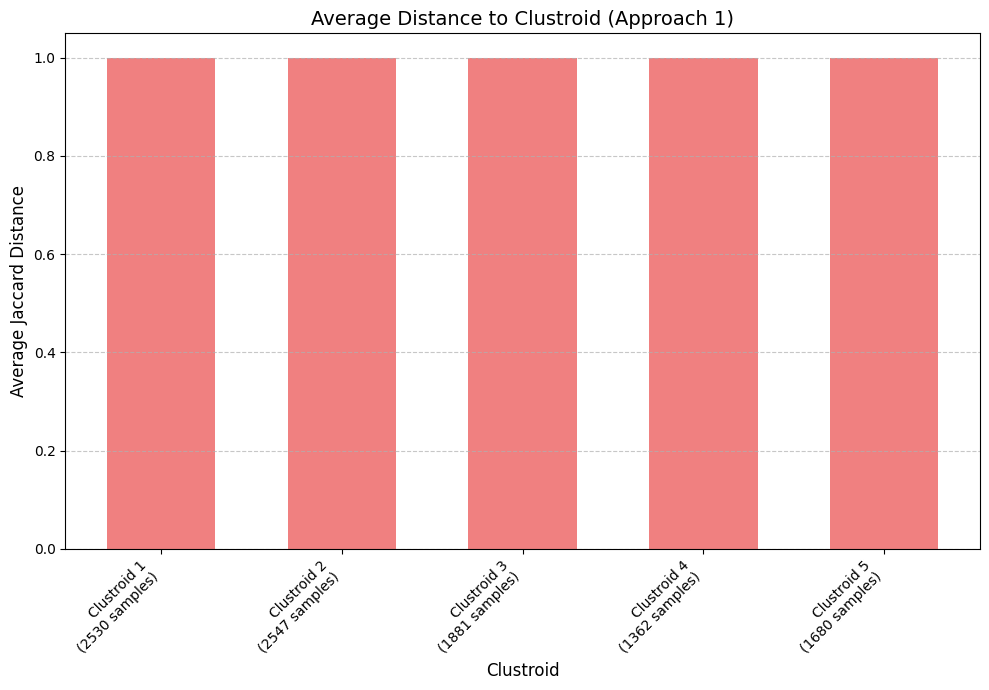

Thời gian thí nghiệm: 443.32 giây
Tổng thời gian: 1535.51 giây
Hoàn thành Task 1.


In [12]:
print("\n--- Bước 3: Đọc dữ liệu, Chạy AHC và Thí nghiệm ---")
start_time = time.time()
try:
    df_input_data = pd.read_csv(CSV_FILENAME)
except FileNotFoundError:
    print(f"LỖI: File '{CSV_FILENAME}' không tìm thấy.")
    raise SystemExit

df_input_data['shingles'] = df_input_data['shingles'].apply(lambda x: set(ast.literal_eval(x)))
print(f"Đã đọc dữ liệu: {len(df_input_data)} mẫu")
print(f"Thời gian đọc dữ liệu: {time.time() - start_time:.2f} giây")

if SAMPLE_SIZE_FOR_CLUSTERING < len(df_input_data):
    df_for_clustering = df_input_data.sample(n=SAMPLE_SIZE_FOR_CLUSTERING, random_state=42).reset_index(drop=True)
else:
    df_for_clustering = df_input_data.reset_index(drop=True)

list_of_shingle_sets_for_clustering = df_for_clustering['shingles'].tolist()
print(f"Number of samples for clustering: {len(list_of_shingle_sets_for_clustering)}")

# Chạy AHC
ahc_model = AgglomerativeHierarchicalClustering(distance_metric_func=jaccard_distance)
final_clusters = ahc_model.fit(list_of_shingle_sets_for_clustering, num_target_clusters=NUM_FINAL_CLUSTERS_TARGET)
final_clusters_info = ahc_model.get_final_cluster_details()
print(f"Number of final clusters: {len(final_clusters_info)}")

# Tính khoảng cách trung bình
start_time = time.time()
avg_dist_to_clustroid_per_cluster = []
cluster_sizes_for_plotting = []
for cluster_idx, cluster_data in enumerate(final_clusters_info):
    clustroid_shingles = cluster_data['clustroid_shingles']
    member_shingles = cluster_data['member_shingle_sets']
    if not member_shingles or clustroid_shingles is None:
        avg_dist_to_clustroid_per_cluster.append(0)
        cluster_sizes_for_plotting.append(0)
        continue
    total_dist = sum(jaccard_distance(member, clustroid_shingles) for member in member_shingles)
    num_members = len(member_shingles)
    avg_dist = total_dist / num_members if num_members > 0 else 0
    avg_dist_to_clustroid_per_cluster.append(avg_dist)
    cluster_sizes_for_plotting.append(num_members)
    print(f"Cluster {cluster_idx+1}: Avg Distance = {avg_dist:.4f}, Number of Samples = {num_members}")

# Vẽ biểu đồ
if avg_dist_to_clustroid_per_cluster:
    plt.figure(figsize=(10, 7))
    bar_labels = [f'Clustroid {i+1}\n({cluster_sizes_for_plotting[i]} samples)' for i in range(len(avg_dist_to_clustroid_per_cluster))]
    plt.bar(bar_labels, avg_dist_to_clustroid_per_cluster, color='lightcoral', width=0.6)
    plt.xlabel("Clustroid", fontsize=12)
    plt.ylabel("Average Jaccard Distance", fontsize=12)
    plt.title(f"Average Distance to Clustroid (Approach 1)", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
print(f"Thời gian thí nghiệm: {time.time() - start_time:.2f} giây")

print(f"Tổng thời gian: {time.time() - start_time_total:.2f} giây")
print("Hoàn thành Task 1.")